# Data Augmentation From Human Data
In this notebook we will perform a data augmentation task using the human data from the dataset. We will ue gemini to generate new data from the human data.

## Setup
First we import all the used libraries in the next section as well as the configuration for the gemini client

In [1]:
import json
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

from google import genai


In [2]:
client = genai.Client(api_key=os.environ["API_KEY"])

## Data exploration
We start from a very small dataset collected by a physician to used to create a chatbot about hypertension.
The dataset is composed of sentences and responses to those sentences.

In [3]:
# Load the data
df = pd.read_csv("data/raw-data-human.csv")

In [4]:
df.head()

,Sentence,Response
0,quali sono i trattamenti disponibili per l’ipe...,Le terapie per l'ipertensione arteriosa includ...
1,Ho avuto mal di testa frequenti.,I mal di testa non sono necessariamente legati...
2,Non ho paura della mia ipertensione.,"E' corretto, non è necessario temere l'iperten..."
3,"Ciao, assistente! Spero che tu possa darmi qua...","Ciao, oggi posso dirti chei tuoi valori medi n..."
4,hai mai provato a dipingere?,Sono un chatbot progettato per fornire suppor...


To analyse the data, we combine both the sentence and the response in a single text. This will allow us to embed the data and peform clustering

In [5]:
# Combine Sentence and Response text in this pattern: ### Sentence ### {Sentence content} ### Response ### {Response content}

df["text"] = "### Sentence ### " + df["Sentence"] + " ### Response ### " + df["Response"]

df["text"].head()

0    ### Sentence ### quali sono i trattamenti disp...
1    ### Sentence ### Ho avuto mal di testa frequen...
2    ### Sentence ### Non ho paura della mia iperte...
3    ### Sentence ### Ciao, assistente! Spero che t...
4    ### Sentence ### hai mai provato a dipingere? ...
Name: text, dtype: object

The embedding is performed with an LLM model from generative AI (a google service). With this embedding we can see any patterns in the data. This will allow us to perform a fair sampling of the dataset

In [26]:

max_batch = 100
embeddings = []

for i in range(0, len(df), max_batch):
    start_index = i
    end_index = min(i + max_batch, len(df))
    print(f"Processing batch {i // max_batch + 1} of {len(df) // max_batch + 1}, start index {start_index}, end index {end_index}")
    batch_embedding = client.models.embed_content(
        model="models/text-embedding-004",
        contents=df["text"][start_index:end_index].tolist(),
    )
    embeddings.extend(batch_embedding.embeddings)

Processing batch 1 of 2, start index 0, end index 100
Processing batch 2 of 2, start index 100, end index 127


In [33]:
embeddings = [embedding.values for embedding in embeddings]

## Embedding visualization and clustering
To visualize the embeddings we will reduce the dimensionality of the embeddings to 3 dimensions using PCA.
After that we will perform a clustering using Mean Shift.

In [34]:
# reduce the dimensionality of the embeddings, using PCA from sklearn
pca = PCA(n_components=3)
pca.fit(embeddings)

PCA(n_components=3)

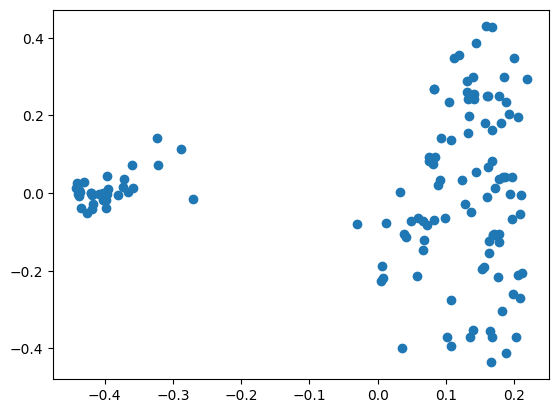

In [36]:
data = pca.transform(embeddings)
plt.scatter(data[:, 0], data[:, 1])

In [37]:
# Mean shift clustering
mean_shift = MeanShift()
mean_shift.fit(data)

MeanShift()

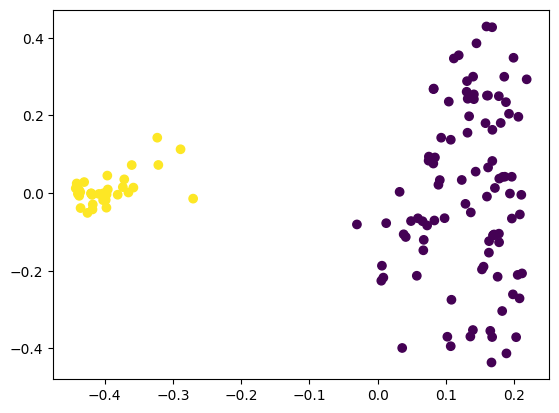

In [38]:
# Plot the clusters
plt.scatter(data[:, 0], data[:, 1], c=mean_shift.labels_)

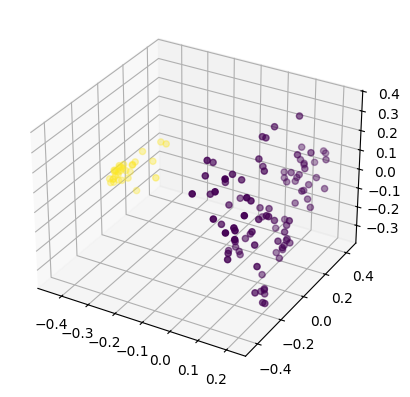

In [39]:
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=mean_shift.labels_)

Looking at the clusters data, it seems that the left cluster correspond to the question wich the chatbot cannot anwer (out of scope).

In [40]:
# Print 2 sample for each cluster
print(f"Number of clusters: {max(mean_shift.labels_) + 1}")
for cluster in range(max(mean_shift.labels_) + 1):
    print(f"Cluster {cluster}")
    for i in range(2):
        print(df["text"][mean_shift.labels_ == cluster].iloc[i])
    print()

Number of clusters: 2
Cluster 0
### Sentence ### quali sono i trattamenti disponibili per l’ipertensione? ### Response ### Le terapie per l'ipertensione arteriosa includono trattamenti non farmacologici come le modifiche dello stile di vita, ad esempio maggiore attività fisica, riduzione dell'introito di sale con la dieta, e trattamenti farmacologici che includono diversi farmaci antipertensivi
### Sentence ### Ho avuto mal di testa frequenti. ### Response ### I mal di testa non sono necessariamente legati alla pressione alta. Ti consiglio di parlarne con il tuo medico.

Cluster 1
### Sentence ### hai mai provato a dipingere? ### Response ###  Sono un chatbot progettato per fornire supporto nella gestione dell'ipertensione. La tua domanda non è correlata al mio ambito di competenza.
### Sentence ### Ho avuto problemi di udito. ### Response ###  Sono un chatbot progettato per fornire supporto nella gestione dell'ipertensione. La tua domanda non è correlata al mio ambito di competenza.



## Data augmentation
In this part, will sample the 40% of the data trying to be balanced between the two cluster identified.

In [41]:
# Sample 40% total, give more weight to the clusters with more samples
sampling_ratio = 0.4
sampled_sentences = []
sampled_indices = []
for cluster in range(max(mean_shift.labels_) + 1):
    cluster_indices = df.index[mean_shift.labels_ == cluster]

    n_samples = int(len(cluster_indices) * sampling_ratio)
    random_sample = np.random.choice(cluster_indices, n_samples, replace=False)

    sampled_indices.extend(random_sample)
    sampled_sentences.extend(df["text"][random_sample])



In [42]:
len(sampled_indices)

50

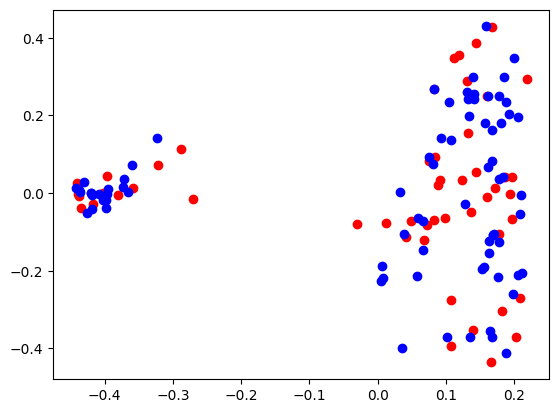

In [43]:
# Plot sampled indices embedding and not sampled

sampled_data = data[sampled_indices]
not_sampled_data = np.delete(data, sampled_indices, axis=0)

plt.scatter(sampled_data[:, 0], sampled_data[:, 1], c="red")
plt.scatter(not_sampled_data[:, 0], not_sampled_data[:, 1], c="blue")

This is the prompt preparation used to generate new data from the sampled data. We will generate 5 new sentence - response pairs for each sentence in the sampled data. It encode also the all dataset to try avoiding to generate the same data.

In [44]:
# Data augmentation

def prompt_generation(knowledge, text):
    return f"""
    I will share with you a dataset of responses to sentences. In this form:
    ### Sentence ### <knowledge> ### Response ### <text>
    After this knowledge, I will share just one of those sentences with you.
    Your task it to generate five different sentence - response pairs that could follow the sentence I shared with you but that should be different from the responses in the dataset.
    You will reply with a json object with the following structure:

    Use this JSON schema for the reply:

    Data = {{'sentence': str, 'response': str}}
    Return: list[Data]

    knowledge:
    {knowledge}
    This is the pair used to generate five different sentence - response pairs (use the same tone and style as the dataset):
    {text}
    """

In [45]:
knowledge = " ".join(sampled_sentences)
prompt_generation(knowledge, sampled_sentences[0])

"\n    I will share with you a dataset of responses to sentences. In this form:\n    ### Sentence ### <knowledge> ### Response ### <text>\n    After this knowledge, I will share just one of those sentences with you.\n    Your task it to generate five different sentence - response pairs that could follow the sentence I shared with you but that should be different from the responses in the dataset.\n    You will reply with a json object with the following structure:\n\n    Use this JSON schema for the reply:\n\n    Data = {'sentence': str, 'response': str}\n    Return: list[Data]\n\n    knowledge:\n    ### Sentence ### Mi sento un po’ stanco e ho notato che la mia pressione sanguigna è più alta del solito. ### Response ### Non sempre c'è correlazione tra la pressione e i sintomi riferiti. Per i sintomi ti consigliamo di parlarne con il tuo Medico di Medicina Generale. ### Sentence ### ho fatto nuove misurazioni, posso inviartele? ### Response ### Certamente! ### Sentence ### Posso inseri

From the prompt generation we will generate the new data using the gemini service.

In [52]:
import time
all_prompts = [prompt_generation(knowledge, text) for text in sampled_sentences]

response = []
current_prompt = 0

for prompt in tqdm(all_prompts):
    response.append(client.models.generate_content(
        model='gemini-2.0-flash-exp',
        contents=prompt
    ))
    current_prompt += 1
    # sleep to avoid resource exhaustion
    time.sleep(5)


100%|██████████| 50/50 [09:31<00:00, 11.44s/it]


In [53]:
len(response)

50

The response from the gemini service is a json object that we need to clean to extract the sentence and response. In particular, we need to remove the code block from the response.

In [54]:
cleaned_responses = []

for r in response:

    response_text = r.text.replace("```json", "").replace("```", "")
    response_json = json.loads(response_text)

    cleaned_responses.append(response_json)


We separate the sentence and response in two different lists

In [48]:
flatten_sentences = []
flatten_responses = []

for r in cleaned_responses:
    for data in r:
        flatten_sentences.append(data["sentence"])
        flatten_responses.append(data["response"])


In [49]:
len(flatten_sentences), len(flatten_responses)

(250, 250)

Add the sampled data from the original distribution in the new data

In [73]:
flatten_sentences.extend(df["Sentence"][sampled_indices])
flatten_responses.extend(df["Response"][sampled_indices])
len(flatten_sentences), len(flatten_responses)


(350, 350)

The new dataset is created as the previous one

In [51]:
df_generated = pd.DataFrame({
    "Sentence": flatten_sentences,
    "Response": flatten_responses,
})
df_generated["text"] = "### Sentence ### " + df_generated["Sentence"] + " ### Response ### " + df_generated["Response"]

In [52]:
# generate embeddings
embeddings_generated = client.models.embed_content(
        model="models/text-embedding-004",
        content=df_generated["text"].tolist(),
)

### Data visualization as before
In this part we will visualize the new data and the original data
Hopefully the new data will be more diverse but in the same distribution

In [67]:
# reduce the dimensionality of the embeddings, using PCA from sklearn

pca_all = PCA(n_components=3)
pca_all.fit(embeddings_generated['embedding'] + embeddings['embedding'])

PCA(n_components=3)

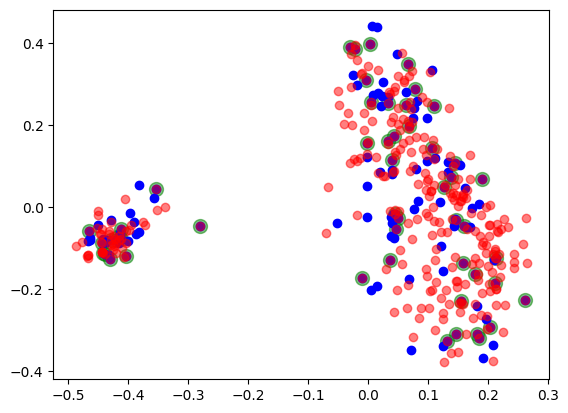

In [72]:
# show both embeddings

data_generated = pca_all.transform(embeddings_generated['embedding'])
data = pca_all.transform(embeddings['embedding'])
data_sampled = data[sampled_indices]
# scatter the sampled data
plt.scatter(data_sampled[:, 0], data_sampled[:, 1], c="green", label="Sampled", alpha=0.5, s=100)
plt.scatter(data[:, 0], data[:, 1], c="blue")
plt.scatter(data_generated[:, 0], data_generated[:, 1], c="red", label="Generated", alpha=0.5)

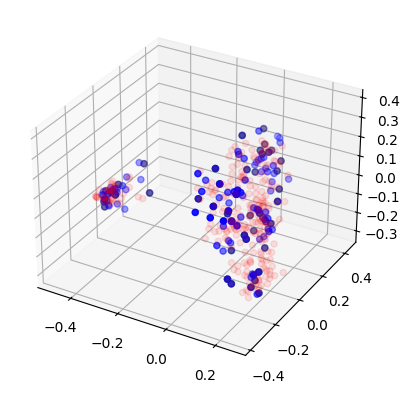

In [76]:

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c="blue")
ax.scatter(data_generated[:, 0], data_generated[:, 1], data_generated[:, 2], c="red", alpha=0.1)
ax.scatter(data_sampled[:, 0], data_sampled[:, 1], data_sampled[:, 2], c="green")


In [77]:
# store just the generated data, without text
to_store = df_generated[["Sentence", "Response"]]

to_store.to_csv("data/generated-data.csv", index=False)

In [78]:
# Perform clustering on the generated data

mean_shift_generated = MeanShift()

mean_shift_generated.fit(data_generated)

MeanShift()

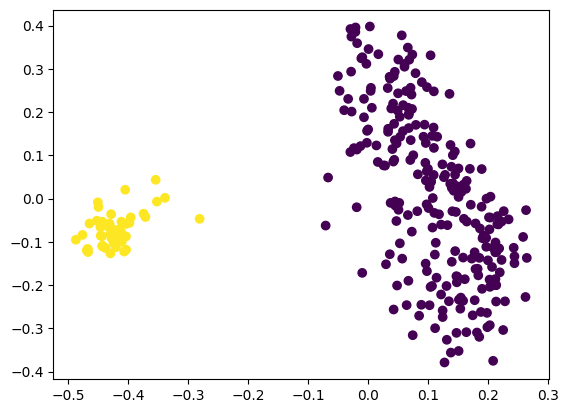

In [79]:
# Plot the clusters
plt.scatter(data_generated[:, 0], data_generated[:, 1], c=mean_shift_generated.labels_)

In [80]:
# as text, get all the non-sampled data
df_not_sampled = df.drop(sampled_indices)
to_store_not_sampled = df_not_sampled[["Sentence", "Response"]]
to_store_not_sampled.to_csv("data/not-sampled-data.csv", index=False)

In [81]:
# convert Sentence and Response to text_input output

df_generated["text_input"] = df_generated["Sentence"]
df_generated["output"] = df_generated["Response"]
# store the generated data, only the text_input and output

to_store_generated = df_generated[["text_input", "output"]]
to_store_generated.to_csv("data/generated-data-text-input-output.csv", index=False)